In [2]:
%autosave 0

# Dependencies
from splinter import Browser
from bs4 import BeautifulSoup as bs
import requests
import os
import pandas as pd
import pymongo
import time
import re

Autosave disabled


In [3]:
# mongodb connection
conn = 'mongodb://localhost:27017'
client = pymongo.MongoClient(conn)

db = client.job_description_db2

In [3]:
# Initialize executable path for the chromedriver
executable_path = {'executable_path': 'chromedriver.exe'}
browser = Browser('chrome', **executable_path, headless=False)

In [4]:
base_url = 'https://stackoverflow.com/tags?page='

In [5]:
skill_list = []
ct_total_list = []
ct_week_list = []

In [6]:
for next_page in range(1,31):
    
    new_url = base_url + str(next_page) + "&tab=popular"
    browser.visit(new_url)
    html = browser.html
    soup = bs(html, 'html.parser')

    tag_card = soup.find('div', class_="grid-layout")
    
    for i in range(36):
        tag_name = tag_card.find_all('div', class_='grid-layout--cell')[i].a.text
        tag_question_ct = tag_card.find_all('span', class_='item-multiplier-count')[i].text
        
        try:
            tag_week_ct = tag_card.find_all('div', class_='grid--cell stats-row')[i]('a')[1].text
        except:
            tag_week_ct = "0 this week"     
        
        #print(tag_name + " " + tag_question_ct + " " + tag_week_ct)    
        
        if "-" in tag_name:
            tag_name = tag_name.replace("-", " ")    
        skill_list.append(tag_name)
        
        ct_total_list.append(int(tag_question_ct))
        
        if "week" in tag_week_ct:
            tag_week_ct = float(tag_week_ct.replace(' this week', ''))
        elif "month" in tag_week_ct:
            tag_week_ct = float(tag_week_ct.replace(' this month', ''))/4
        elif "year" in tag_week_ct:
            tag_week_ct = float(tag_week_ct.replace(' this year', ''))/52
        
        tag_week_ct = int(tag_week_ct)
        ct_week_list.append(tag_week_ct)

In [7]:
len(ct_week_list)

1080

In [8]:
len(ct_total_list)

1080

In [9]:
len(skill_list)

1080

In [10]:
skill_df = pd.DataFrame({"Skill": skill_list, "Total Questions": ct_total_list, "Weekly Questions": ct_week_list})

In [11]:
skill_df.head(15)

,Skill,Total Questions,Weekly Questions
0,javascript,1794705,5050
1,java,1537465,3824
2,c#,1303551,2882
3,php,1277142,2703
4,android,1187694,2637
5,python,1151834,6230
6,jquery,950786,1174
7,html,817017,1952
8,c++,613771,1403
9,ios,596021,894


In [12]:
db.stackoverflow_skills.insert_many(skill_df.to_dict('records'))

In [14]:
documents = db.jd.find()

# tags = db.stackoverflow_skills.find()
for doc in documents:
    uid = doc['_id']
    doc['job_skills'] = []
    for tag in skill_df['Skill']:
#         if tag in doc['job_decription']:
        pattern = re.compile(r'\b' + re.escape(tag) + r'\b', flags=re.IGNORECASE)
        paragraph = doc['job_decription']
        if pattern.search(paragraph):
            doc['job_skills'].append(tag)
#     db.jd.update_many({'query_title': 'Data Scientist'}, {'$set': {'job_skills': doc['job_skills']}})
    db.jd.update_many({'_id': uid}, {'$set': {'job_skills': doc['job_skills']}})

In [4]:
counts = {}
documents = db.jd.find()

for doc in documents:
    for skill in doc['job_skills']:
        if skill in counts:
            counts[skill] += 1
        else:
            counts[skill] = 1
print(counts)
#db.skillcounts.insert_one(counts)

{'python': 2935, 'c': 594, 'performance': 1132, 'object': 130, 'tensorflow': 468, 'hadoop': 1077, 'math': 555, 'optimization': 909, 'dynamic': 604, 'model': 1060, 'background': 850, 'localization': 2, 'deep learning': 637, 'statistics': 2272, 'frameworks': 461, 'computer vision': 102, 'position': 1316, 'expression': 436, 'sql': 2010, 'perl': 96, 'join': 1201, 'machine learning': 2621, 'build': 1684, 'reference': 47, 'stream': 26, 'key': 1201, 'java': 860, 'r': 2471, 'mongodb': 127, 'pandas': 320, 'matlab': 403, 'random': 277, 'mobile': 198, 'methods': 1344, 'data structures': 196, 'graph': 171, 'hive': 583, 'keras': 207, 'cassandra': 84, 'process': 981, 'pyspark': 72, 'nosql': 303, 'map': 129, 'set': 500, 'find': 587, 'include': 963, 'package': 376, 'hbase': 95, 'database': 568, 'scala': 561, 'validation': 357, 'shiny': 102, 'architecture': 343, 'sas': 739, 'components': 167, 'authorization': 130, 'cloud': 814, 'web': 491, 'search': 319, 'service': 624, 'location': 656, 'mysql': 130, '

In [8]:
keys, values = zip(*counts.items())
skills_counts_df = pd.DataFrame( {'skills': keys, 'counts':values} )
skills_counts_df.head(10)

,skills,counts
0,python,2935
1,c,594
2,performance,1132
3,object,130
4,tensorflow,468
5,hadoop,1077
6,math,555
7,optimization,909
8,dynamic,604
9,model,1060


In [13]:
skills_counts_df.sort_values('counts', ascending=False, inplace=True)
skills_counts_df.head(10)

,skills,counts
0,python,2935
21,machine learning,2621
27,r,2471
13,statistics,2272
18,sql,2010
66,time,1693
22,build,1684
33,methods,1344
16,position,1316
20,join,1201


In [73]:
import matplotlib.pyplot as plt
%matplotlib inline

top = skills_counts_df.head(50)
#top25.set_index('skills', inplace=True)
top_skills = top['skills']
top_counts = top['counts']


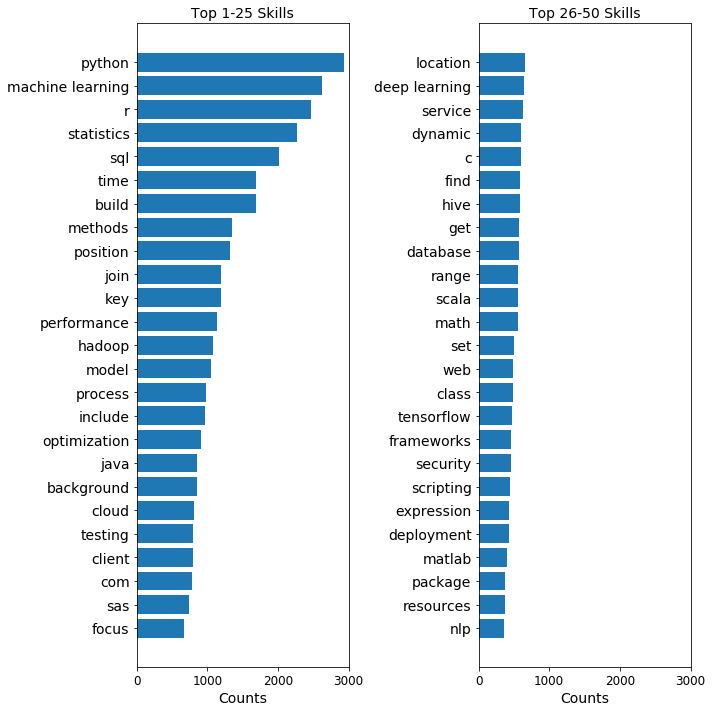

In [93]:

fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)


ax.barh(top_skills[0:25],top_counts[0:25])
ax.set_title('Top 1-25 Skills', fontsize=14)
ax.set_xlabel('Counts', fontsize=14)
ax.set_xlim(0,3000)
ax.tick_params('x',labelsize=12)
ax.tick_params('y',labelsize=14)
ax.invert_yaxis()

ax2.barh(top_skills[25:50],top_counts[25:50])
ax2.set_title('Top 26-50 Skills', fontsize=14)
ax2.set_xlabel('Counts', fontsize=14)
ax2.set_xlim(0,3000)
ax2.tick_params('x',labelsize=12)
ax2.tick_params('y',labelsize=14)
ax2.invert_yaxis()

plt.tight_layout()